In [1]:
from pathlib import Path
from thermophysicalProperties import Database
import matplotlib.pyplot as plt
import numpy as np
from frozendict import frozendict
import pint
ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
from uncertainties import ufloat
import os
from numdifftools import Derivative
from scipy.optimize import minimize
import warnings
import sys
import thermoToolsAdditions as tta
from thermoToolsAdditions import convert_to_thermochem_name

warnings.filterwarnings("ignore")

thermochimica_path = Path("../../thermochimica")
output_path = Path('../outputs')
output_name = 'output.json'
data_file = Path("../../thermochimica/data/MSTDB-TC_V3.0_Chlorides_No_Functions_8-2.dat")
input_file_name = "runThermochimica.ti"

# Get the script name from sys.argv
script_name = sys.argv[0]

# Get the absolute path of the script
script_dir = Path(os.path.abspath(script_name)).resolve().parent

mstdb_tp_path = Path('../../mstdb-tp/Molten_Salt_Thermophysical_Properties.csv')
mstdb_tp_rk_path = Path('../../mstdb-tp/Molten_Salt_Thermophysical_Properties_RK.csv')

db = Database(mstdb_tp_path, mstdb_tp_rk_path)

# Fuel Optimization

For the fuel salt, a chloride salt was chosen, and has been identified as a good choice for fast systems by a number of reactor designers (e.g. Terra Power) due to its relatively high $A$ (minimal moderation) and various fissile components and fission products tend to have high solubilities in chloride melts, making them good fuel carriers. The base components under consideration are
1. $\text{KCl}$
2. $\text{NaCl}$
3. $\text{ZrCl}_4$
4. $\text{AlCl}$
5. $\text{UCl}_3$ (the most common redox state of U in chloride melts)
6. $\text{PuCl}_3$ (also the most common redox state)
7. $\text{NdCl}_3$ (only used as a surrogate for Cm)

A notable exclusion is $\text{MgCl}_2$, which is often considered due to its ability to control redox or lower the melting point of the salt, which can be a concern for chlorides which generally have higher melting points than fluorides although $\text{RbCl}$ can also be used for this purpose, however, no thermophysical properties are currently available in MSTDB-TP, so it has been excluded. Additionally, it was determined that Zr additives would be used for redox control, so Mg is not necesssary. $\text{PuCl}$ and $\text{UCl}$ are both present in the salt, however we will consider their ratio fixed (these components are more relevant for neutronics than thermal hydraulics) and also the fraction of actinides in the fuel salt is also constrained by criticality and fuel cycle requirements. We will perform this calculation with a fixed actinide fraction with the hope that they're soluble at the periphery of the fuel tube, and we will verify this after the fact.

For the fuel salt, the heating requirements are also a concern, and we would like the salt to not have a prohibitively high melting point, but in this design, the fuel salt will actually reach very high temperatures on the centerline, and the boiling temperature of the fuel salt becomes a relevant consideration. To acheive a high power density in the salt (comparable to a LWR at ~100 kW/L) a boiling point of around 1800 K is desirable, based on rudimentary thermohydraulics scoping calculations.

Availability of thermophysical properties
| Pure Compound   | $\rho$ | $\mu$ | $k$  | $c_p$ |
| --------------- | ------ | ----- | ---- | ----- | 
| $\text{KCl}$    |   ✓    |   ✓   |  ✓   |   ✓   |
| $\text{NaCl}$   |   ✓    |   ✓   |  ✓   |   ✓   |
| $\text{ZrCl}_4$ |   ✓    |   ✓   |  ✗   |   ✗   |
| $\text{AlCl}$   |   ✓    |   ✓   |  ✗   |   ✓   |
| $\text{UCl}_3$  |   ✓    |   ✗   |  ✗   |   ✗   |
| $\text{PuCl}_3$ |   ✗    |   ✗   |  ✗   |   ✓   |
| $\text{NdCl}_3$ |   ✓    |   ✓   |  ✗   |   ✓   |

Which is admittedly quite sparse, but is more than sufficient to fully calculate all of the thermophysical properties of a salt of interest (so long as we don't exclude some endmembers).

## Optimization Methodology
An important consideration in the fuel sallt is the centerline temperature. In our design, since molten salt is a relatively poor conductor, the centerline can reach _very_ high temperatures, and the constraint then becomes the fuel salt melting point. The temperature profile (assuming pure conduction) is parabolic, and the centerline temperature is given by
$$
    T(0) = \frac{\dot{q}r_o^2}{4k} + T_\infty + \frac{\dot{q}r_o}{2h}\nonumber
$$
Where $T(0)$ is the centerline temperature, $\dot{q}$ is the volumetric heat generation rate within the rod (our target is around 100 kW/L), $r_o$ is the outer fuel rod radius, $k$ is the fuel salt thermal conductivity, $h$ is the heat transfer coefficient from the outer rod surface to the coolant salt (which is not affected by the fuel salt), and $T_\infty$ is the bulk coolant temperature away from the thermal boundary layer near the rod surface. From this expression, it's clear that increasing the thermal conductivity of the fuel salt and/or raising its boiling point will loosen the constraints on our design. However, we also want our fuel salt to melt at a reasonable temperature (say 800-900 K). So our goal will be to maximize the thermal conductivity while keeping the melting point below 800-900 K, and the boiling point above 2000 K.

## Actinide Composition
The fuel composition is (representing an actinide fraction of 55 mole %): $\text{PuCl}_3$ - $\text{NdCl}_3$ - $\text{UCl}_3$ ($39.8$ - $0.2$ - $15.0$ mole %) which is notably _mostly_ $\text{PuCl}_3$, the rest of the fuel salt (45 mole %) is unconstrained. 

In [2]:
T_max = 900 # Maximum melting point
T_min = 1900

actinide_composition = np.array([0.398, 0.002, 0.15])

def check_melting_and_boiling(x, endmembers, elements_used):
    x = np.append(x, 0.45-sum(x))
    x = np.append(x, actinide_composition)

    # Convert from NaF to Na F (unfortunate mismatch in convention)
    new_endmembers = [convert_to_thermochem_name(endmember) for endmember in endmembers]
    salt = dict({endmember: x[i] for i, endmember in enumerate(new_endmembers)})

    try:
        T_m, T_b = tta.calculate_melting_and_boiling(thermochimica_path, output_path, output_name, data_file, salt, elements_used, \
                                                   suppress_output=True, phase_tolerance=0.9)
        return min(T_max - T_m, T_b - T_min)
    except:
        # Return a large negative value to indicate that the constriaint was not satisfied
        return -1E+06 # The supplied salt does not have a melting or boiling point in the given range (it could be that the salt sublimates)
    
# A constraint function which ensures that sum(x) = 1
def constraint(x):
    return 0.45 - np.sum(x)

# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint})

In [3]:
T_f = 1350 # Assumed average fuel temperature in K

# Define the objective function
def objective(x, endmembers):
    x = np.append(x, 0.45-sum(x))
    x = np.append(x, actinide_composition)
    salt = frozendict({endmember: x[i] for i, endmember in enumerate(endmembers)})
    try:
        k = db.get_tp('thermal_conductivity', salt)(T_f).nominal_value
    except OverflowError:
        return 1E+03
    objective = k
    if np.isnan(objective) or np.isinf(objective):
        return 1E+03
    else:
        return -objective

In [4]:
endmembers = ['NaCl', 'KCl', 'AlCl3', 'ZrCl4', 'PuCl3', 'NdCl3', 'UCl3']
elements_used = ['Cl', 'Na', 'K', 'Al', 'Zr', 'Pu', 'Nd', 'U']

# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint}, \
        {'type': 'ineq', 'fun': check_melting_and_boiling, 'args': (endmembers, elements_used)})

guess = [0.3, 0.05, 0.05] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 1), (0.001, 1)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={
        'verbose': 3, 
        'gtol': 1e-3, 
        'xtol': 1e-3, 
        'maxiter': 200,
        'initial_constr_penalty': 50.0,
        'initial_tr_radius': 1.0,
        'initial_barrier_tolerance': 0.1
    },
    args=endmembers
)


Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x7290a9a23960 in ???
#1  0x7290a9a22ac5 in ???
#2  0x7290a964251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x589764b46555 in ???
#4  0x589764b3ba97 in ???
#5  0x589764ba5356 in ???
#6  0x589764ba83ef in ???
#7  0x589764b36b99 in ???
#8  0x589764b37206 in ???
#9  0x589764b960f9 in ???
#10  0x589764b2dfdb in ???
#11  0x589764b2bb97 in ???
#12  0x589764b2a3c8 in ???
#13  0x7290a9629d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x7290a9629e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x589764b2a3f4 in ???
#16  0xffffffffffffffff in ???


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   4   |   0   | -4.5007e-01 | 1.00e+00 | 8.81e-02 | 1.00e+06 | 5.00e+01 |  1.00e-01   |   0   |
|   2   |   8   |   2   | -4.5007e-01 | 5.00e-01 | 8.81e-02 | 1.00e+06 | 5.00e+01 |  1.00e-01   |   2   |
|   3   |  12   |   3   | -4.5007e-01 | 2.81e+00 | 9.05e-02 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   4   |
|   4   |  16   |   5   | -4.5007e-01 | 2.81e+00 | 3.31e-02 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   4   |
|   5   |  20   |   7   | -4.5007e-01 | 1.57e+01 | 2.04e-02 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   4   |
|   6   |  24   |   9   | -4.5007e-01 | 1.57e+01 | 7.98e-03 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   4   |
|   7   |  28   |  11   | -4.5007e-01 | 1.57e+00 | 7.98e-03 | 0.00e+00 | 5.00e+01 |  1.00e-01   |   4   |
|   8   |  28   |  13   | -4.5007e-01 | 5.41e-


Program received signal SIGFPE: Floating-point exception - erroneous arithmetic operation.

Backtrace for this error:
#0  0x700354023960 in ???
#1  0x700354022ac5 in ???
#2  0x700353c4251f in ???
	at ./signal/../sysdeps/unix/sysv/linux/x86_64/libc_sigaction.c:0
#3  0x61fcab1d0555 in ???
#4  0x61fcab1c5a97 in ???
#5  0x61fcab22f356 in ???
#6  0x61fcab2323ef in ???
#7  0x61fcab1c0b99 in ???
#8  0x61fcab1c1206 in ???
#9  0x61fcab2200f9 in ???
#10  0x61fcab1b7fdb in ???
#11  0x61fcab1b5b97 in ???
#12  0x61fcab1b43c8 in ???
#13  0x700353c29d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#14  0x700353c29e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#15  0x61fcab1b43f4 in ???
#16  0xffffffffffffffff in ???


|  93   |  392  |  133  | -4.4748e-01 | 1.00e+00 | 6.26e-04 | 0.00e+00 | 5.00e+01 |  6.40e-06   |   4   |

`gtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 392, CG iterations: 133, optimality: 6.26e-04, constraint violation: 0.00e+00, execution time: 4.3e+04 s.


In [5]:
result

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -0.4474750240482934
                 x: [ 2.578e-01  5.000e-02  9.225e-02]
               nit: 93
              nfev: 392
              njev: 98
              nhev: 0
          cg_niter: 133
      cg_stop_cond: 4
              grad: [-6.994e-02  3.606e-01  0.000e+00]
   lagrangian_grad: [-6.257e-04 -1.287e-17  4.794e-04]
            constr: [array([ 4.997e-02]), array([ 4.141e+01]), array([ 2.578e-01,  5.000e-02,  9.225e-02])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00]]), array([[ 0.000e+00, -6.711e+13,  0.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00],
                           [ 0.000e+00,  0.000e+00,  1.000e+00]])]
       constr_nfev: [392, 392, 0]
       constr_njev: [0, 0, 0]
       constr_nhev: [0, 0, 0]
                 v: [array([-5.870e-02]), array([ 6.2

So the optimum is $\text{NaCl}$ - $\text{KCl}$ - $\text{AlCl}_3$ - $\text{ZrCl}_4$ - $\text{PuCl}_3$ - $\text{NdCl}_3$ - $\text{UCl}_3$ ( $0.95$ - $0.01$ - $16.0$ - $28.04$ - $39.8$ - $0.2$ - $15.0$ mole %)

In [14]:
test_composition = {'Na Cl': 0.0095, 'K Cl': 0.0001, 'Al Cl_3': 0.16, 'Zr Cl_4': 0.2804, 'Pu Cl_3': 0.398, 'Nd Cl_3': 0.002, 'U Cl_3': 0.15}
tta.calculate_melting_and_boiling(thermochimica_path, output_path, output_name, data_file, \
                                             test_composition, elements_used, ntstep=150)

Thermochimica calculation initiated.
Thermochimica calculation finished.


ValueError: Either the specified liquid or gas phase was not present over the temperature range of the calculation. The following phases were present throughout the calculation: 
P63_M 0.40 P63_M#7 0.16
P63_M 0.40 P63_M#7 0.16
P63_M 0.40 P63_M#7 0.16
MSCL 0.00 P63_M 0.43
MSCL 0.05 P63_M 0.15 P63_M#7 0.39
MSCL 0.05 P63_M 0.39 P63_M#7 0.15
MSCL 0.05 P63_M 0.15 P63_M#7 0.39
MSCL 0.06 P63_M 0.15 P63_M#7 0.39
MSCL 0.07 P63_M 0.14 P63_M#7 0.39
gas_ideal 0.07 MSCL 0.07 P63_M 0.15 P63_M#7 0.43
gas_ideal 0.07 MSCL 0.06 P63_M 0.14 P63_M#7 0.43
gas_ideal 0.07 MSCL 0.06 P63_M 0.13 P63_M#7 0.45
gas_ideal 0.08 MSCL 0.06 P63_M 0.58
gas_ideal 0.08 MSCL 0.05 P63_M 0.58
gas_ideal 0.08 MSCL 0.05 P63_M 0.58
gas_ideal 0.09 MSCL 0.05 P63_M 0.58
gas_ideal 0.12 MSCL 0.05 P63_M 0.58
gas_ideal 0.22 MSCL 0.05 P63_M 0.58
gas_ideal 0.38 MSCL 0.04 P63_M 0.58
gas_ideal 0.38 MSCL 0.04 P63_M 0.58
gas_ideal 0.38 MSCL 0.04 P63_M 0.58
gas_ideal 0.38 MSCL 0.04 P63_M 0.58
gas_ideal 0.38 MSCL 0.04 P63_M 0.58
gas_ideal 0.38 MSCL 0.04 P63_M 0.57
gas_ideal 0.38 MSCL 0.04 P63_M 0.57
gas_ideal 0.39 MSCL 0.04 P63_M 0.57
gas_ideal 0.39 MSCL 0.04 P63_M 0.57
gas_ideal 0.39 MSCL 0.04 P63_M 0.57
gas_ideal 0.39 MSCL 0.04 P63_M 0.56
gas_ideal 0.40 MSCL 0.04 P63_M 0.56
gas_ideal 0.40 MSCL 0.04 P63_M 0.56
gas_ideal 0.41 MSCL 0.04 P63_M 0.56
gas_ideal 0.41 MSCL 0.03 P63_M 0.56
gas_ideal 0.41 MSCL 0.03 P63_M 0.56
gas_ideal 0.42 MSCL 0.02 P63_M 0.56
gas_ideal 0.39 MSCL 0.31 P63_M 0.30
gas_ideal 0.37 MSCL 0.42 P63_M 0.21
gas_ideal 0.37 MSCL 0.48 P63_M 0.15
gas_ideal 0.36 MSCL 0.54 P63_M 0.10
gas_ideal 0.35 MSCL 0.61 P63_M 0.04
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.34 MSCL 0.66
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.35 MSCL 0.65
gas_ideal 0.36 MSCL 0.64
gas_ideal 0.36 MSCL 0.64
gas_ideal 0.36 MSCL 0.64
gas_ideal 0.36 MSCL 0.64
gas_ideal 0.37 MSCL 0.63
gas_ideal 0.37 MSCL 0.63
gas_ideal 0.37 MSCL 0.63
gas_ideal 0.38 MSCL 0.62
gas_ideal 0.38 MSCL 0.62
gas_ideal 0.38 MSCL 0.62
gas_ideal 0.39 MSCL 0.61
gas_ideal 0.40 MSCL 0.60
gas_ideal 0.40 MSCL 0.60
gas_ideal 0.41 MSCL 0.59
gas_ideal 0.42 MSCL 0.58
gas_ideal 0.43 MSCL 0.57
gas_ideal 0.44 MSCL 0.56
gas_ideal 0.45 MSCL 0.55
gas_ideal 0.46 MSCL 0.54
gas_ideal 0.48 MSCL 0.52
gas_ideal 0.50 MSCL 0.50
gas_ideal 0.52 MSCL 0.48
gas_ideal 0.54 MSCL 0.46
gas_ideal 0.57 MSCL 0.43
gas_ideal 0.60 MSCL 0.40
gas_ideal 0.63 MSCL 0.37
gas_ideal 0.68 MSCL 0.32
gas_ideal 0.73 MSCL 0.27
gas_ideal 0.79 MSCL 0.21
gas_ideal 0.86 MSCL 0.14
gas_ideal 0.96 MSCL 0.04
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00
gas_ideal 1.00

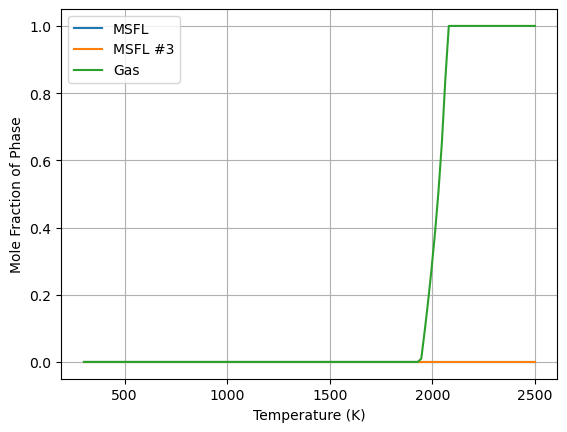

In [13]:
output = tta.thermoOut(output_path / output_name)
temperatures = output.temperatures.values()
mole_fraction_liquid = output.get_phase_fraction('MSCL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSCL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, np.array(mole_fraction_liquid) + np.array(mole_fraction_liquid_3), label='MSCL')
plt.plot(temperatures, mole_fraction_liquid_3, label='MSCL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()